<a href="https://colab.research.google.com/github/snsk/_sandbox/blob/main/Deeplearning_Image_Classification_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow.kerasで体験する画像認識モデル開発プロセス

## 講義概要と目的

tf.keras のCNN（畳み込みニューラルネットワーク）を使って2種類の画像を識別する画像認識モデルの開発を体験する。典型的な機械学習(ディープラーニング)モデルの開発のプロセスを学ぶことで、AI案件における課題を理解しやすくする。

## 対象

*    学習モデル（教師あり）の開発をざっと確認、体験したい人
*    MNIST（手書き数字認識）はやってみたけど結局何をやってるのか分からず詳細を知りたい人

## 受講資格

*   Python初級レベル

<hr>

# 講義メモ

## 何をやるか

1. 犬と猫を識別するモデルを100枚で作ってみる
2. 正確度がいまいち
3. Data augmentation（データの水増し）をする
4. 正確度が上がる
5. モデルを保存する
6. 保存したモデルを使って1枚を識別する

## 何を実装するのか

大きく分けて、

1. 必要なライブラリのインポート
2. 画像を読み込んで色相、サイズ、2次元配列 & numpy arrayへ変換
3. 正解ラベルをone-hotベクトルに変換
4. 訓練用データと評価用データを仕分ける
5. モデルを構築する
6. 損失関数、最適化アルゴリズム、メトリクスを指定してコンパイルする
7. 訓練用データを利用して訓練する
8. 訓練結果を図表で確認する
9. 満足いく結果になるまで、手順5～8を繰り返す

上記のステップを辿る

## 畳み込みニューラルネットワークモデル

* Conv2D: 2次元畳み込み層
* MaxPooling2D: 物体の位置ずれに対応するプーリング層
* Dropout: ランダムでノードを不活性化させて過学習を防ぐ
* Flatten: 2次元データを1次元に変換する
* Dence: 全結合層。前の層までの結果をすべて結合する


※このモデル構成はkerasのexampleに昔あったもの。いまなぜか無くなっているが、多くの画像認識のチュートリアルで未だに採用されている。
https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py#L39

### Conv2D層, Pooling層の説明

* 画像を使ったほうが分かりやすいので以下で解説
https://docs.google.com/presentation/d/11RgJqQZ8AsOyExEUsn8ny2Wfn88isFa7Fmt9a9deKjo/edit#slide=id.ge9f92f8e16_0_77

## 損失関数、最適化アルゴリズム、メトリクス

* 学習モデルの訓練は基本的に損失関数（期待結果とのズレ）を最小化する方向に向かう
* 与えられたデータの特徴を適切に抑えられていない状態が「学習不足(underfitting)」。学習一般的ではない特徴まで学習してしまっている状態を「過学習（overfitting）」という

### 損失関数

損失関数にはさまざまな種類があり、作りたいモデルによって最適な関数が異なる

* N個の説明変数から1つの目的変数を求める＝線形回帰モデルを作りたい場合
  * 平均二乗誤差 / mean_squared_error
    * 最もメジャー。外れ値に敏感で結果が不安定になりやすい
  * 平均絶対誤差 / mean_absolute_error
    * 外れ値に強いが、誤差に対して鈍感。
  * 平均二乗対数誤差 / mean_squared_logarithmic_error
    * 外れ値に強い。数式が人間に分かりにくい。
* 分類問題を解くモデルを作りたい場合
  * 交差エントロピー誤差 / categorical_crossentropy
    * 多クラス分類のとき
  * 二値交差エントロピー誤差 / binarybinary_crossentropy
    * 二値クラス分類のとき

### 最適化アルゴリズム

* パラメータをどう調整すると素早く損失をゼロに近づけられるか？というアプローチのこと
* 最急降下法（勾配降下法）
  * パラメータで損失関数を微分することで損失を降下(小さく)する方向を逐次的に探してその方向にパラメータを調整させていく
  * 要するに、無数のパラメータ平面において微分を取り上るか下るかを決める

* 図表を交えた詳しい解説はここが良さそう
  * https://qiita.com/omiita/items/1735c1d048fe5f611f80

* 各アルゴリズムの特徴
  * SGD	最も基本となるアルゴリズム・勾配の方向に進む
  * momentumSGD	SGD＋「速度」と「慣性」の概念
  * AdaGrad	学習が進むほど学習率を小さくしていく
  * RMSprop	AdaGrad＋最近の勾配ほど強く影響
  * AdaDelta	単位をそろえる
  * Adam	momentumSGD＋RMSprop
  * 引用元：https://tech-lab.sios.jp/archives/21823
  * 参考(STAR機械学習WGの解説)：
    * https://docs.google.com/presentation/d/1KvtcOVaxl8BUqOtp6vqioC7l-aRO7U54mcv5KruPNFM/edit#slide=id.p15


* 結論。現在のkerasでは Adam で。

## モデルの訓練

### バッチサイズとエポック数

* 最近の最適化アルゴリズムでは、ミニバッチ勾配降下法と確率的勾配降下法の中間をとったアルゴリズムが用いられるケースがほとんど。
  * 学習に使うデータセットをいくつかのサブセットに分割する
  * これがバッチサイズ（ミニバッチと呼ばれることもある）
  * バッチサイズの指定は慣習として2のN乗が使われることが多い
  * 数百件程度であれば32, 64あたり。
  * イテレーション数＝バッチサイズ/データサイズ
  * エポック数＝イテレーション数*NのN
* 最適なエポック数は、損失関数が収束するまで。つまり、やってみないとわからない

## 損失関数グラフ

* 基本的には損失関数がほぼ収束（0に近づく）ことを狙っていく

---




# 最終成果物：2種類の画像を識別するモデル

最終的に出来上がる成果物。このモデルでは、犬と猫を識別している。

Epoch 1/25
26/26 [==============================] - 3s 108ms/step - loss: 0.7580 - accuracy: 0.5148 - val_loss: 0.6900 - val_accuracy: 0.6749
Epoch 2/25
26/26 [==============================] - 3s 98ms/step - loss: 0.6887 - accuracy: 0.5524 - val_loss: 0.6818 - val_accuracy: 0.5419
Epoch 3/25
26/26 [==============================] - 3s 98ms/step - loss: 0.6576 - accuracy: 0.6541 - val_loss: 0.6616 - val_accuracy: 0.5714
Epoch 4/25
26/26 [==============================] - 3s 98ms/step - loss: 0.6024 - accuracy: 0.6880 - val_loss: 0.5586 - val_accuracy: 0.7611
Epoch 5/25
26/26 [==============================] - 3s 98ms/step - loss: 0.5554 - accuracy: 0.7275 - val_loss: 0.4939 - val_accuracy: 0.7882
Epoch 6/25
26/26 [==============================] - 3s 98ms/step - loss: 0.5035 - accuracy: 0.7540 - val_loss: 0.4185 - val_accuracy: 0.8054
Epoch 7/25
26/26 [==============================] - 3s 99ms/step - loss: 0.4681 - accuracy: 0.7830 - val_loss: 0.3893 - val_accuracy: 0.8374
Epoch 8/25
2

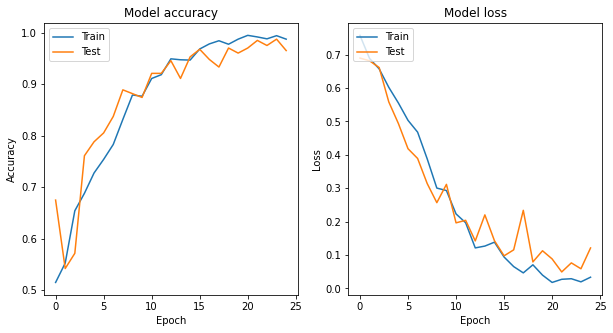

13/13 [==============================] - 0s 20ms/step - loss: 0.1212 - accuracy: 0.9655
[0.1211826279759407, 0.9655172228813171]
Test:
13/13 [==============================] - 0s 19ms/step - loss: 0.1212 - accuracy: 0.9655

Test accuracy: 0.9655172228813171


In [ ]:
import numpy as np
import keras.optimizers
import glob
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from PIL import Image
from pprint import pprint

folder = ["dog_1000","cat_1000"]
image_size = 100
X = []
Y = []
for index, name in enumerate(folder):
    dir = "/content/drive/MyDrive/colab_root/" + name
    files = glob.glob(dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)

X = np.array(X)
Y = np.array(Y)

X = X.astype('float32')
X = X / 255.0

# 正解ラベルの形式を変換
Y = np_utils.to_categorical(Y, 2)

# 学習用データとテストデータを切り分ける
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
'''
X_train:訓練用入力データ
X_test :訓練用正解データ
Y_train:評価用入力データ
Y_test :評価用正解データ
'''

# CNNを構築
# Sequentialモデルは addされたモデル層が一列に並ぶ
model = Sequential()

#Conv2D:2次元畳み込み層 2x2のパネルを32枚使う。padding='same' で出力画像のサイズが変わらないようにする
model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

#モデルのコンパイル
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#モデルの訓練
epochs_num=25
result = model.fit(X_train, Y_train, batch_size=64, epochs=epochs_num, validation_data=(X_test, Y_test))

#modelのテキスト可視化。Sequentialモデルならこれでも十分、らしい
#print(model.summary())

#modelのビジュアル可視化。要install and PATH setting GraphViz, pydot。functional API を利用した複雑なモデルの時はこちら
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='./model.png', show_shapes=True, expand_nested=True)

#model.save('ramen_hiyashi.h5')

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5)) # グラフのサイズ

# Plot training & validation accuracy values
plt.subplot(1,2,1) # 1つめのグラフ

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2) # 2つめのグラフ
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
    
plt.show() # グラフを表示する

#評価 & 評価結果出力
print(model.evaluate(X_test, Y_test))
print('Test:')
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)
print('\nTest accuracy:', test_acc)

# Kerasによる画像データの拡張：Data augmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

colab_root = '/content/drive/MyDrive/colab_root/'

# 画像を読み込む。
img = image.load_img(colab_root+'ramen_1.jpg')
img = np.array(img)

plt.imshow(img)
plt.show()

# flow に渡すために配列を四次元化
img = img[None, ...]

# 画像変形のジェネレータを作成
datagen = image.ImageDataGenerator(rotation_range=50)
gen = datagen.flow(img, batch_size = 1)

# バッチの実行
batches = next(gen)
# 画像として表示するためにuint8に変換
g_img = batches[0].astype(np.uint8)

plt.imshow(g_img)
plt.show()


# 構築済みのモデルを使う



In [ ]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

colab_root = '/content/drive/MyDrive/colab_root/'

# modelと画像ファイルの読み込み
model = load_model(colab_root + 'ramen_hiyashi_acc0.9675.h5')

# 画像ファイルの行列変換
img = img_to_array(load_img(colab_root + 'ramen_2.jpg', target_size=(100,100)))
img_nad = img_to_array(img)/255
img_nad = img_nad[None, ...]

# 正解ラベルの定義
label=['ramen', 'hiyashi']

# 判別
pred = model.predict(img_nad, batch_size=1, verbose=0)
print(pred)
score = np.max(pred)
pred_label = label[np.argmax(pred[0])]
print('name:',pred_label)
print('score:',score)

[[0.7606613  0.23933864]]
name: ramen
score: 0.7606613



# np_arrayとimg_nad の動作確認

In [ ]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from IPython.display import display

colab_root = '/content/drive/MyDrive/colab_root/'

# modelと画像ファイルの読み込み
model = load_model(colab_root + 'ramen_hiyashi_acc0.9675.h5')

# 画像ファイルの行列変換
img = img_to_array(load_img(colab_root + 'ramen_2.jpg', target_size=(100,100)))
display(img)
img_nad = img_to_array(img)/255
img_nad = img_nad[None, ...]
display(img_nad)

# 行列の積和演算

In [ ]:
import numpy as np

image  = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 0]])
filter = np.array([[0, 1, 2], [1, 2, 0], [2, 0, 1]])

momx = np.sum(image * filter, 1)
print(np.sum(momx))

14


# colab sandbox

In [ ]:
!python -V

Python 3.7.11
